# Lesson 4: Learning Representations + Style Transfer

Look into what a network learns

Examine Representations (RSMs)

Extract these for content loss

Style loss: Gramm matrix version

Style loss: OT version

## Aside: NBDEV and exporting functions for later use

## Aside: Making Gradio Demos (and use as exercise)

## Aside: Imstack

Video: What do networks learn?

Look at https://distill.pub/2017/feature-visualization/ and show some of that

Look at https://distill.pub/2021/multimodal-neurons/ for some fancier concepts in CLIP

Talk about fine-tuning a little and link to bonus content on that

In [ ]:
# TODO: Include AEs/VAEs? 
# TODO: Contrastive loss anywhere?

In [ ]:
import torch 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd

# Adding on from last lesson:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torchvision.models import vgg16, VGG16_Weights
from tqdm.notebook import tqdm

## Style Transfer

Remember how we said that early layers in a network tend to learn simpler features like colour and texture, while later layers capture more complex shapes? We're going to take advantage of this to do a little bit of magic. We'll take two images, a content image and a style image. Then we'll feed both through a network and record the activations at various layers.

Now we can start with noise or begin with the content image, and set it up as a tensor to be optimised. Then, we start tweaking it such that when we feed it through the same big network the activations in the early layers ('style') are similar to those of the style image while the activations of later layers, more linked to overall structure and shapes ('content') match the content image. 

In effect we're trying to minimise some combination of two loss functions, a style loss and a content loss. 

First, let's look at a pretrained network and pull some features from it:

### Extracting Represenations from Pretrained Models

VGG16 was a fairly popular CNN that improved upon the famous AlexNet architecture. It has since been supeceeded by more complex networks but it still works great for our purposes. The architecture is something like the following (source [link text](https://https://neurohive.io/en/popular-networks/vgg16/)):

![architecture](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

We can load it like so (check the imports section at the start of this notebook for the relevant imports):

In [ ]:
vgg = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

In [ ]:
# vgg # Uncomment to show the sumary

I adapted some code from [here](https://www.kaggle.com/danmoller/easy-style-transfer-with-pytorch) to create a feature extractor that will record the outputs of neurons in specified layers:

In [ ]:
#VGG16 Feature Extractor 

# Ref: https://www.kaggle.com/danmoller/easy-style-transfer-with-pytorch

class VGGFeatureExtractor(nn.Module):
    def __init__(self, vggModel, layerIndices):
        super(VGGFeatureExtractor,self).__init__()
        self.features = vggModel.features
        
        #desired layers
        self.layerIndices = layerIndices
        self.outputCount = len(layerIndices)
        
        #making this model's parameters untrainble
        for p in self.parameters():
            p.requires_grad = False
        
    def forward(self,x):
        outputs = list()  #outputs from the selected layers
        
        #for each layer in the VGG
        for i, layer in enumerate(self.features.children()):
            x = layer(x) #apply the layer
            
            #if this layer is a desired layer, store its outputs
            if i in self.layerIndices:
                outputs.append(x)
                
                #check if we got all desired layers
                if i == self.layerIndices[-1]:
                    return outputs
                    
        return outputs


To test it out, let's download a couple of images which we'll later use to try style transfer:

TODO find new images :)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58417  100 58417    0     0   263k      0 --:--:-- --:--:-- --:--:--  264k


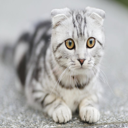

In [ ]:
#@title content_image
!curl --output cat.jpeg "https://images.pexels.com/photos/156934/pexels-photo-156934.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
content_image = Image.open('cat.jpeg').resize((128, 128))
content_image

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  201k  100  201k    0     0   824k      0 --:--:-- --:--:-- --:--:--  825k


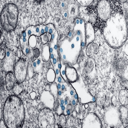

In [ ]:
#@title style_image
!curl --output style.jpeg "https://images.pexels.com/photos/3992944/pexels-photo-3992944.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"
style_image = Image.open('style.jpeg').resize((128, 128))
style_image

In [ ]:
from tglcourse.utils import * # TODO change name to l1?

extracting the activations from a few later layers to serve as our content features:

In [ ]:
content_im_tensor = pil_to_tensor(content_image)
contentExtractor = VGGFeatureExtractor(vgg,  [15, 19])
target_content_features = contentExtractor(content_im_tensor)
# View the shapes of the extracted features (one tensor for each layer):
[t.shape for t in target_content_features] 

[torch.Size([1, 256, 32, 32]), torch.Size([1, 512, 16, 16])]

And likewise from some early layers to use in the style loss:

In [ ]:
styleExtractor = VGGFeatureExtractor(vgg,[5, 7, 10, 12, 17])
style_im_tensor = pil_to_tensor(style_image)
target_style_features = styleExtractor(style_im_tensor)
[t.shape for t in target_style_features] 

[torch.Size([1, 128, 64, 64]),
 torch.Size([1, 128, 64, 64]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 256, 32, 32]),
 torch.Size([1, 512, 16, 16])]

We feed in an image and get back these tensors recording the activations of various neurons in specific layers of the network - the 'internal representations' which we'll use in our loss functions.

## Defining the Loss Functions

For our content loss we'll keep things simple, with a measure of how large the differences between the two sets of features are (l1 loss, think of it as mean absolute error):

In [ ]:
def content_loss(im, target_content_features):
  im_content_features = contentExtractor(im)
  loss = 0
  for im_features, target_features in zip(im_content_features, target_content_features):
    loss += nn.L1Loss()(im_features, target_features)
  return loss/len(im_content_features)

im = torch.rand(1, 3, 128, 128) # A dummy input image
content_loss(im, target_content_features)

tensor(2.7075)

The style loss is a little more tricky. We want to measure the occurence of similar features, but we don't care so much where they occur in the image. Using L1 loss as above would mean it just tried to copy the style image (layout and all). To get around this, we create something called a gram matrix for each set of features, and compare these gram matrices instead of comparing the features directly. This is one of those things where most tutorials/explanations online don't give any explanation for why we do this specifically, and I don't know the theory myself so we're going going to roll with this ¯\_(ツ)_/¯

In [ ]:
# TODO explain gram loss and add new version based on optimal transport (or leave that the the separate losses and gens bonus notebook?)

In [ ]:
# The gram matrix
def gram(x):
	b,c,h,w = x.size();
	x = x.view(b*c, -1);
	return torch.mm(x, x.t())/(h*w) # /(h*w) normalizes by size to avoid over-focusing on early layers
 
def style_loss(im, target_style_features):
  im_style_features = styleExtractor(im)
  loss = 0
  for im_features, target_features in zip(im_style_features, target_style_features):
    im_gram = gram(im_features)
    target_gram = gram(target_features)
    loss += F.mse_loss(im_gram, target_gram);
  return loss/len(im_style_features)

style_loss(im, target_style_features)

tensor(201.9189)

NB: These two losses are quite different size-wise. This can sometimes mean that one will 'overpower' the other. We'll partly address this by adding some parameters to scale both losses and adjust how much each one contributes to the final loss value. In this case you'll also notice that while the style_loss starts out high it rapidly falls as small changes to the image being optimised take effect.

## Optimization loop

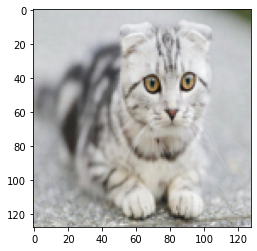

43.43103790283203


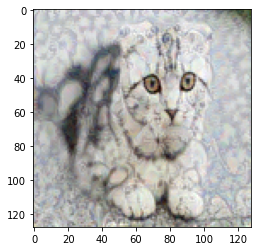

3.355156421661377


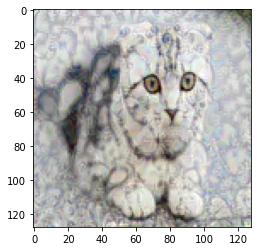

2.7192649841308594


[<matplotlib.lines.Line2D>]

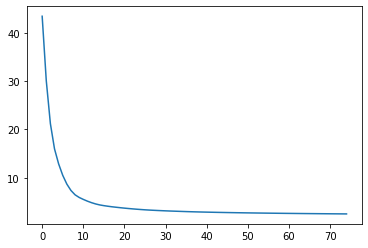

In [ ]:
# Start with a copy of the content image
im = pil_to_tensor(content_image)
im.requires_grad = True

# Optimizer
optimizer = torch.optim.AdamW([im], lr=5e-3)

# Weights we'll give to the different losses
style_weight, content_weight = 0.5, 1

# The training loop (look familiar yet?)
losses = []  # keeping recods of loss
for i in range(75):
  optimizer.zero_grad()  # set gradients to 0
  loss = style_weight * style_loss(im.clip(0, 1), target_style_features)
  loss += content_weight * content_loss(im.clip(0, 1), target_content_features)
  loss.backward()  # Compute gradients (backward pass)
  optimizer.step()  # update parameters (optimizer takes a step)

  # Storing our loss for later viewing
  losses.append(loss.item())

  # Showing the progress occasionally
  if i % 25 == 0:
    plt.imshow(im.clip(0, 1).detach().squeeze().permute(1, 2, 0))
    plt.show()
    print(loss.item())

# Plot the losses over time
plt.plot(losses) # Plot the losses over time

In [ ]:
# TODO re-write code for clarity
# Add the non-style-transfer stuff
# Video or two